In [1]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset.git


Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163235, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 163235 (delta 2), reused 0 (delta 0), pack-reused 163229 (from 1)
Receiving objects: 100% (163235/163235), 2.00 GiB | 37.94 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (182401/182401), done.


# reloading model from cv_alexnet1 and retraining


Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 672s 487ms/step - accuracy: 0.9753 - loss: 0.0742 - val_accuracy: 0.9780 - val_loss: 0.0679
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 637s 469ms/step - accuracy: 0.9819 - loss: 0.0602 - val_accuracy: 0.9620 - val_loss: 0.1110
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 636s 469ms/step - accuracy: 0.9819 - loss: 0.0536 - val_accuracy: 0.9820 - val_loss: 0.0564
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 638s 470ms/step - accuracy: 0.9815 - loss: 0.0515 - val_accuracy: 0.9827 - val_loss: 0.0571
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 636s 468ms/step - accuracy: 0.9853 - loss: 0.0432 - val_accuracy: 0.9827 - val_loss: 0.0532
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9861 - loss: 0.0437


Test Accuracy after fine-tuning: 98.67%
340/340 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9861 - loss: 0.0437
Test Accuracy: 98.67%


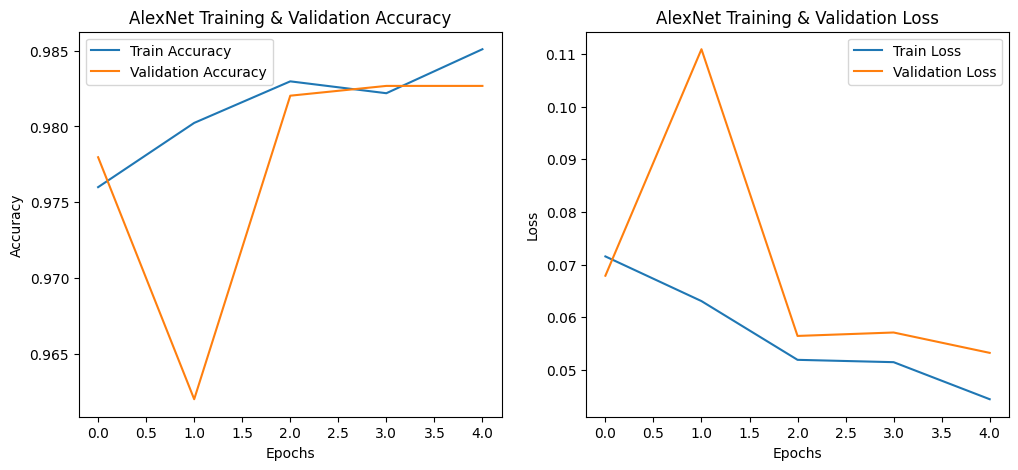

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split

dataset_dir = "/content/PlantVillage-Dataset/raw/color"

# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  
)

# Train dataset (60%)
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation dataset (20%)
val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  
)

# Test dataset (20%) - Different subset
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',  
    shuffle=False
)

# Define AlexNet model
def build_alexnet(input_shape, num_classes):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((3, 3), strides=2),

        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((3, 3), strides=2),

        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Get the number of classes from train_generator
num_classes = train_generator.num_classes
input_shape = (224, 224, 3)  # Image shape

from tensorflow.keras.models import load_model
alexnet_model = load_model("/content/AlexNet_PlantDisease.h5")

# Optionally unfreeze last few layers for fine-tuning
for layer in alexnet_model.layers[-5:]:
    layer.trainable = True

# Compile with a lower learning rate for fine-tuning
alexnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
history_alexnet = alexnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  
    batch_size=32
)

# Evaluate on test set
test_loss, test_acc = alexnet_model.evaluate(test_generator)
print(f"Test Accuracy after fine-tuning: {test_acc * 100:.2f}%")

# Save the updated model
alexnet_model.save("alexnet_plant_disease_finetuned.h5")

# Evaluate the model on the test set
test_loss, test_acc = alexnet_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy & loss graphs
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('AlexNet Training & Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('AlexNet Training & Validation Loss')

    plt.show()

# Call the function to plot graphs
plot_training_history(history_alexnet)


# Final accuracy 98.67%


In [ ]:
alexnet_model.save('/content/drive/MyDrive/alexnet_plant_disease_finetuned.h5')  # Saves as HDF5 file
